In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_2048_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_basal_seg_data_norm_b25_targets_t1_native_k5_b25_t1_0_42_n_native_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(884582, 834)
(884582, 3)
validation
(154411, 834)
(154411, 3)
test
(115112, 834)
(115112, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 834)]             0         


 dense (Dense)               (None, 2048)              1710080   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 3)                 387       


Total params: 4497667 (17.16 MB)


Trainable params: 4497667 (17.16 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


1/9 [==>...........................] - ETA: 1:17 - loss: 1.1076 - STD: 0.0647 - MAE: 0.4415

2/9 [=====>........................] - ETA: 2s - loss: 1.1141 - STD: 0.1045 - MAE: 0.4334  

3/9 [=========>....................] - ETA: 2s - loss: 1.1125 - STD: 0.1147 - MAE: 0.4314

4/9 [============>.................] - ETA: 1s - loss: 1.1045 - STD: 0.1126 - MAE: 0.4308

5/9 [===============>..............] - ETA: 1s - loss: 1.0990 - STD: 0.1028 - MAE: 0.4318

6/9 [===================>..........] - ETA: 1s - loss: 1.0979 - STD: 0.0915 - MAE: 0.4334

7/9 [======================>.......] - ETA: 3s - loss: 1.0970 - STD: 0.0850 - MAE: 0.4344

8/9 [=========================>....] - ETA: 1s - loss: 1.0950 - STD: 0.0827 - MAE: 0.4346

9/9 [==============================] - ETA: 0s - loss: 1.0929 - STD: 0.0826 - MAE: 0.4345

9/9 [==============================] - 23s 2s/step - loss: 1.0929 - STD: 0.0826 - MAE: 0.4345 - val_loss: 1.0743 - val_STD: 0.0866 - val_MAE: 0.4318


Epoch 2/10000


1/9 [==>...........................] - ETA: 5s - loss: 1.0743 - STD: 0.0867 - MAE: 0.4317

2/9 [=====>........................] - ETA: 2s - loss: 1.0768 - STD: 0.0904 - MAE: 0.4316

3/9 [=========>....................] - ETA: 2s - loss: 1.0786 - STD: 0.0934 - MAE: 0.4314

4/9 [============>.................] - ETA: 1s - loss: 1.0793 - STD: 0.0950 - MAE: 0.4312

5/9 [===============>..............] - ETA: 1s - loss: 1.0791 - STD: 0.0952 - MAE: 0.4311

6/9 [===================>..........] - ETA: 1s - loss: 1.0784 - STD: 0.0939 - MAE: 0.4312

7/9 [======================>.......] - ETA: 0s - loss: 1.0776 - STD: 0.0906 - MAE: 0.4316

8/9 [=========================>....] - ETA: 0s - loss: 1.0774 - STD: 0.0861 - MAE: 0.4322

9/9 [==============================] - ETA: 0s - loss: 1.0774 - STD: 0.0819 - MAE: 0.4328

9/9 [==============================] - 4s 439ms/step - loss: 1.0774 - STD: 0.0819 - MAE: 0.4328 - val_loss: 1.0769 - val_STD: 0.0526 - val_MAE: 0.4370


Epoch 3/10000


1/9 [==>...........................] - ETA: 5s - loss: 1.0774 - STD: 0.0527 - MAE: 0.4370

2/9 [=====>........................] - ETA: 2s - loss: 1.0761 - STD: 0.0579 - MAE: 0.4362

3/9 [=========>....................] - ETA: 2s - loss: 1.0753 - STD: 0.0632 - MAE: 0.4353

4/9 [============>.................] - ETA: 1s - loss: 1.0749 - STD: 0.0675 - MAE: 0.4347

5/9 [===============>..............] - ETA: 1s - loss: 1.0747 - STD: 0.0705 - MAE: 0.4342

6/9 [===================>..........] - ETA: 1s - loss: 1.0746 - STD: 0.0727 - MAE: 0.4338

7/9 [======================>.......] - ETA: 0s - loss: 1.0747 - STD: 0.0744 - MAE: 0.4336

8/9 [=========================>....] - ETA: 0s - loss: 1.0746 - STD: 0.0755 - MAE: 0.4334

9/9 [==============================] - ETA: 0s - loss: 1.0743 - STD: 0.0763 - MAE: 0.4332

9/9 [==============================] - 4s 445ms/step - loss: 1.0743 - STD: 0.0763 - MAE: 0.4332 - val_loss: 1.0718 - val_STD: 0.0804 - val_MAE: 0.4323


Epoch 4/10000


1/9 [==>...........................] - ETA: 4s - loss: 1.0710 - STD: 0.0807 - MAE: 0.4320

2/9 [=====>........................] - ETA: 2s - loss: 1.0710 - STD: 0.0775 - MAE: 0.4325

3/9 [=========>....................] - ETA: 2s - loss: 1.0712 - STD: 0.0737 - MAE: 0.4330

4/9 [============>.................] - ETA: 1s - loss: 1.0713 - STD: 0.0703 - MAE: 0.4335

5/9 [===============>..............] - ETA: 1s - loss: 1.0713 - STD: 0.0683 - MAE: 0.4337

6/9 [===================>..........] - ETA: 1s - loss: 1.0711 - STD: 0.0681 - MAE: 0.4337

7/9 [======================>.......] - ETA: 0s - loss: 1.0707 - STD: 0.0689 - MAE: 0.4335

8/9 [=========================>....] - ETA: 0s - loss: 1.0704 - STD: 0.0700 - MAE: 0.4333

9/9 [==============================] - ETA: 0s - loss: 1.0699 - STD: 0.0708 - MAE: 0.4331

9/9 [==============================] - 4s 449ms/step - loss: 1.0699 - STD: 0.0708 - MAE: 0.4331 - val_loss: 1.0645 - val_STD: 0.0763 - val_MAE: 0.4310


Epoch 5/10000


1/9 [==>...........................] - ETA: 4s - loss: 1.0637 - STD: 0.0771 - MAE: 0.4306

2/9 [=====>........................] - ETA: 2s - loss: 1.0624 - STD: 0.0794 - MAE: 0.4299

3/9 [=========>....................] - ETA: 2s - loss: 1.0602 - STD: 0.0803 - MAE: 0.4292

4/9 [============>.................] - ETA: 1s - loss: 1.0581 - STD: 0.0789 - MAE: 0.4288

5/9 [===============>..............] - ETA: 1s - loss: 1.0553 - STD: 0.0780 - MAE: 0.4283

6/9 [===================>..........] - ETA: 1s - loss: 1.0520 - STD: 0.0773 - MAE: 0.4276

7/9 [======================>.......] - ETA: 0s - loss: 1.0478 - STD: 0.0777 - MAE: 0.4265

8/9 [=========================>....] - ETA: 0s - loss: 1.0428 - STD: 0.0780 - MAE: 0.4253

9/9 [==============================] - ETA: 0s - loss: 1.0395 - STD: 0.0848 - MAE: 0.4230

9/9 [==============================] - 4s 453ms/step - loss: 1.0395 - STD: 0.0848 - MAE: 0.4230 - val_loss: 1.0605 - val_STD: 0.1043 - val_MAE: 0.4256


Epoch 6/10000


1/9 [==>...........................] - ETA: 4s - loss: 1.0386 - STD: 0.1014 - MAE: 0.4213

2/9 [=====>........................] - ETA: 2s - loss: 1.0081 - STD: 0.1131 - MAE: 0.4105

3/9 [=========>....................] - ETA: 2s - loss: 1.0075 - STD: 0.1342 - MAE: 0.4040

4/9 [============>.................] - ETA: 1s - loss: 0.9963 - STD: 0.1307 - MAE: 0.4026

5/9 [===============>..............] - ETA: 1s - loss: 0.9924 - STD: 0.1293 - MAE: 0.4024

6/9 [===================>..........] - ETA: 1s - loss: 0.9895 - STD: 0.1368 - MAE: 0.3994

7/9 [======================>.......] - ETA: 0s - loss: 0.9836 - STD: 0.1409 - MAE: 0.3969

8/9 [=========================>....] - ETA: 0s - loss: 0.9821 - STD: 0.1411 - MAE: 0.3967

9/9 [==============================] - ETA: 0s - loss: 0.9764 - STD: 0.1434 - MAE: 0.3948

9/9 [==============================] - 4s 450ms/step - loss: 0.9764 - STD: 0.1434 - MAE: 0.3948 - val_loss: 0.9775 - val_STD: 0.1961 - val_MAE: 0.3777


Epoch 7/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.9562 - STD: 0.1952 - MAE: 0.3731

2/9 [=====>........................] - ETA: 2s - loss: 0.9425 - STD: 0.1796 - MAE: 0.3758

3/9 [=========>....................] - ETA: 2s - loss: 0.9408 - STD: 0.1756 - MAE: 0.3771

4/9 [============>.................] - ETA: 1s - loss: 0.9402 - STD: 0.1823 - MAE: 0.3744

5/9 [===============>..............] - ETA: 1s - loss: 0.9366 - STD: 0.1845 - MAE: 0.3728

6/9 [===================>..........] - ETA: 1s - loss: 0.9381 - STD: 0.1843 - MAE: 0.3734

7/9 [======================>.......] - ETA: 0s - loss: 0.9365 - STD: 0.1870 - MAE: 0.3720

8/9 [=========================>....] - ETA: 0s - loss: 0.9355 - STD: 0.1896 - MAE: 0.3707

9/9 [==============================] - ETA: 0s - loss: 0.9347 - STD: 0.1893 - MAE: 0.3707

9/9 [==============================] - 4s 447ms/step - loss: 0.9347 - STD: 0.1893 - MAE: 0.3707 - val_loss: 0.9514 - val_STD: 0.1921 - val_MAE: 0.3735


Epoch 8/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.9159 - STD: 0.1897 - MAE: 0.3666

2/9 [=====>........................] - ETA: 2s - loss: 0.9189 - STD: 0.1965 - MAE: 0.3645

3/9 [=========>....................] - ETA: 2s - loss: 0.9181 - STD: 0.1956 - MAE: 0.3646

4/9 [============>.................] - ETA: 1s - loss: 0.9189 - STD: 0.1931 - MAE: 0.3659

5/9 [===============>..............] - ETA: 1s - loss: 0.9175 - STD: 0.1932 - MAE: 0.3656

6/9 [===================>..........] - ETA: 1s - loss: 0.9180 - STD: 0.1947 - MAE: 0.3650

7/9 [======================>.......] - ETA: 0s - loss: 0.9172 - STD: 0.1943 - MAE: 0.3651

8/9 [=========================>....] - ETA: 0s - loss: 0.9175 - STD: 0.1935 - MAE: 0.3655

9/9 [==============================] - ETA: 0s - loss: 0.9167 - STD: 0.1937 - MAE: 0.3652

9/9 [==============================] - 4s 461ms/step - loss: 0.9167 - STD: 0.1937 - MAE: 0.3652 - val_loss: 0.9451 - val_STD: 0.2015 - val_MAE: 0.3687


Epoch 9/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.9146 - STD: 0.1981 - MAE: 0.3630

2/9 [=====>........................] - ETA: 2s - loss: 0.9120 - STD: 0.1930 - MAE: 0.3645

3/9 [=========>....................] - ETA: 2s - loss: 0.9120 - STD: 0.1907 - MAE: 0.3655

4/9 [============>.................] - ETA: 1s - loss: 0.9105 - STD: 0.1918 - MAE: 0.3647

5/9 [===============>..............] - ETA: 1s - loss: 0.9099 - STD: 0.1929 - MAE: 0.3642

6/9 [===================>..........] - ETA: 1s - loss: 0.9096 - STD: 0.1924 - MAE: 0.3643

7/9 [======================>.......] - ETA: 0s - loss: 0.9084 - STD: 0.1928 - MAE: 0.3639

8/9 [=========================>....] - ETA: 0s - loss: 0.9079 - STD: 0.1943 - MAE: 0.3632

9/9 [==============================] - ETA: 0s - loss: 0.9070 - STD: 0.1951 - MAE: 0.3626

9/9 [==============================] - 4s 448ms/step - loss: 0.9070 - STD: 0.1951 - MAE: 0.3626 - val_loss: 0.9393 - val_STD: 0.2010 - val_MAE: 0.3671


Epoch 10/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.9035 - STD: 0.1987 - MAE: 0.3604

2/9 [=====>........................] - ETA: 2s - loss: 0.9026 - STD: 0.2032 - MAE: 0.3584

3/9 [=========>....................] - ETA: 2s - loss: 0.9018 - STD: 0.2031 - MAE: 0.3583

4/9 [============>.................] - ETA: 1s - loss: 0.9010 - STD: 0.2020 - MAE: 0.3585

5/9 [===============>..............] - ETA: 1s - loss: 0.9005 - STD: 0.2029 - MAE: 0.3580

6/9 [===================>..........] - ETA: 1s - loss: 0.8998 - STD: 0.2030 - MAE: 0.3578

7/9 [======================>.......] - ETA: 0s - loss: 0.8990 - STD: 0.2025 - MAE: 0.3579

8/9 [=========================>....] - ETA: 0s - loss: 0.8981 - STD: 0.2033 - MAE: 0.3574

9/9 [==============================] - ETA: 0s - loss: 0.8974 - STD: 0.2036 - MAE: 0.3571

9/9 [==============================] - 4s 447ms/step - loss: 0.8974 - STD: 0.2036 - MAE: 0.3571 - val_loss: 0.9301 - val_STD: 0.2049 - val_MAE: 0.3636


Epoch 11/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.8904 - STD: 0.2021 - MAE: 0.3563

2/9 [=====>........................] - ETA: 2s - loss: 0.8921 - STD: 0.2067 - MAE: 0.3548

3/9 [=========>....................] - ETA: 2s - loss: 0.8916 - STD: 0.2051 - MAE: 0.3554

4/9 [============>.................] - ETA: 1s - loss: 0.8906 - STD: 0.2045 - MAE: 0.3554

5/9 [===============>..............] - ETA: 1s - loss: 0.8908 - STD: 0.2052 - MAE: 0.3551

6/9 [===================>..........] - ETA: 1s - loss: 0.8901 - STD: 0.2044 - MAE: 0.3552

7/9 [======================>.......] - ETA: 0s - loss: 0.8890 - STD: 0.2048 - MAE: 0.3548

8/9 [=========================>....] - ETA: 0s - loss: 0.8885 - STD: 0.2058 - MAE: 0.3543

9/9 [==============================] - ETA: 0s - loss: 0.8883 - STD: 0.2056 - MAE: 0.3544

9/9 [==============================] - 4s 445ms/step - loss: 0.8883 - STD: 0.2056 - MAE: 0.3544 - val_loss: 0.9266 - val_STD: 0.2288 - val_MAE: 0.3529


Epoch 12/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8883 - STD: 0.2250 - MAE: 0.3463

2/9 [=====>........................] - ETA: 2s - loss: 0.8889 - STD: 0.2135 - MAE: 0.3512

3/9 [=========>....................] - ETA: 2s - loss: 0.8880 - STD: 0.2169 - MAE: 0.3495

4/9 [============>.................] - ETA: 1s - loss: 0.8859 - STD: 0.2139 - MAE: 0.3503

5/9 [===============>..............] - ETA: 1s - loss: 0.8840 - STD: 0.2132 - MAE: 0.3502

6/9 [===================>..........] - ETA: 1s - loss: 0.8827 - STD: 0.2138 - MAE: 0.3497

7/9 [======================>.......] - ETA: 0s - loss: 0.8827 - STD: 0.2127 - MAE: 0.3502

8/9 [=========================>....] - ETA: 0s - loss: 0.8826 - STD: 0.2148 - MAE: 0.3493

9/9 [==============================] - ETA: 0s - loss: 0.8830 - STD: 0.2137 - MAE: 0.3498

9/9 [==============================] - 4s 447ms/step - loss: 0.8830 - STD: 0.2137 - MAE: 0.3498 - val_loss: 0.9168 - val_STD: 0.2313 - val_MAE: 0.3496


Epoch 13/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8760 - STD: 0.2275 - MAE: 0.3425

2/9 [=====>........................] - ETA: 2s - loss: 0.8737 - STD: 0.2177 - MAE: 0.3462

3/9 [=========>....................] - ETA: 2s - loss: 0.8736 - STD: 0.2174 - MAE: 0.3463

4/9 [============>.................] - ETA: 1s - loss: 0.8730 - STD: 0.2166 - MAE: 0.3465

5/9 [===============>..............] - ETA: 1s - loss: 0.8731 - STD: 0.2157 - MAE: 0.3469

6/9 [===================>..........] - ETA: 1s - loss: 0.8726 - STD: 0.2175 - MAE: 0.3461

7/9 [======================>.......] - ETA: 0s - loss: 0.8732 - STD: 0.2163 - MAE: 0.3467

8/9 [=========================>....] - ETA: 0s - loss: 0.8750 - STD: 0.2194 - MAE: 0.3457

9/9 [==============================] - ETA: 0s - loss: 0.8766 - STD: 0.2178 - MAE: 0.3467

9/9 [==============================] - 4s 442ms/step - loss: 0.8766 - STD: 0.2178 - MAE: 0.3467 - val_loss: 0.9257 - val_STD: 0.2485 - val_MAE: 0.3437


Epoch 14/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8886 - STD: 0.2444 - MAE: 0.3377

2/9 [=====>........................] - ETA: 2s - loss: 0.8783 - STD: 0.2252 - MAE: 0.3438

3/9 [=========>....................] - ETA: 2s - loss: 0.8745 - STD: 0.2195 - MAE: 0.3455

4/9 [============>.................] - ETA: 1s - loss: 0.8739 - STD: 0.2226 - MAE: 0.3441

5/9 [===============>..............] - ETA: 1s - loss: 0.8734 - STD: 0.2195 - MAE: 0.3453

6/9 [===================>..........] - ETA: 1s - loss: 0.8712 - STD: 0.2197 - MAE: 0.3448

7/9 [======================>.......] - ETA: 0s - loss: 0.8705 - STD: 0.2213 - MAE: 0.3440

8/9 [=========================>....] - ETA: 0s - loss: 0.8708 - STD: 0.2198 - MAE: 0.3448

9/9 [==============================] - ETA: 0s - loss: 0.8701 - STD: 0.2215 - MAE: 0.3439

9/9 [==============================] - 4s 446ms/step - loss: 0.8701 - STD: 0.2215 - MAE: 0.3439 - val_loss: 0.8979 - val_STD: 0.2241 - val_MAE: 0.3486


Epoch 15/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8570 - STD: 0.2193 - MAE: 0.3420

2/9 [=====>........................] - ETA: 2s - loss: 0.8593 - STD: 0.2171 - MAE: 0.3435

3/9 [=========>....................] - ETA: 2s - loss: 0.8626 - STD: 0.2243 - MAE: 0.3410

4/9 [============>.................] - ETA: 1s - loss: 0.8621 - STD: 0.2224 - MAE: 0.3418

5/9 [===============>..............] - ETA: 1s - loss: 0.8613 - STD: 0.2244 - MAE: 0.3407

6/9 [===================>..........] - ETA: 1s - loss: 0.8604 - STD: 0.2249 - MAE: 0.3403

7/9 [======================>.......] - ETA: 0s - loss: 0.8598 - STD: 0.2242 - MAE: 0.3405

8/9 [=========================>....] - ETA: 0s - loss: 0.8597 - STD: 0.2264 - MAE: 0.3395

9/9 [==============================] - ETA: 0s - loss: 0.8597 - STD: 0.2254 - MAE: 0.3399

9/9 [==============================] - 4s 468ms/step - loss: 0.8597 - STD: 0.2254 - MAE: 0.3399 - val_loss: 0.8937 - val_STD: 0.2400 - val_MAE: 0.3407


Epoch 16/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.8580 - STD: 0.2352 - MAE: 0.3354

2/9 [=====>........................] - ETA: 2s - loss: 0.8555 - STD: 0.2292 - MAE: 0.3374

3/9 [=========>....................] - ETA: 2s - loss: 0.8536 - STD: 0.2272 - MAE: 0.3380

4/9 [============>.................] - ETA: 1s - loss: 0.8535 - STD: 0.2283 - MAE: 0.3375

5/9 [===============>..............] - ETA: 1s - loss: 0.8534 - STD: 0.2267 - MAE: 0.3381

6/9 [===================>..........] - ETA: 1s - loss: 0.8528 - STD: 0.2282 - MAE: 0.3373

7/9 [======================>.......] - ETA: 0s - loss: 0.8523 - STD: 0.2275 - MAE: 0.3375

8/9 [=========================>....] - ETA: 0s - loss: 0.8527 - STD: 0.2296 - MAE: 0.3367

9/9 [==============================] - ETA: 0s - loss: 0.8536 - STD: 0.2282 - MAE: 0.3374

9/9 [==============================] - 4s 460ms/step - loss: 0.8536 - STD: 0.2282 - MAE: 0.3374 - val_loss: 0.9175 - val_STD: 0.2675 - val_MAE: 0.3322


Epoch 17/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.8823 - STD: 0.2627 - MAE: 0.3273

2/9 [=====>........................] - ETA: 2s - loss: 0.8901 - STD: 0.2361 - MAE: 0.3412

3/9 [=========>....................] - ETA: 2s - loss: 0.8857 - STD: 0.2421 - MAE: 0.3377

4/9 [============>.................] - ETA: 1s - loss: 0.8752 - STD: 0.2357 - MAE: 0.3384

5/9 [===============>..............] - ETA: 1s - loss: 0.8705 - STD: 0.2308 - MAE: 0.3397

6/9 [===================>..........] - ETA: 1s - loss: 0.8694 - STD: 0.2331 - MAE: 0.3385

7/9 [======================>.......] - ETA: 0s - loss: 0.8670 - STD: 0.2308 - MAE: 0.3390

8/9 [=========================>....] - ETA: 0s - loss: 0.8646 - STD: 0.2294 - MAE: 0.3392

9/9 [==============================] - ETA: 0s - loss: 0.8643 - STD: 0.2314 - MAE: 0.3382

9/9 [==============================] - 4s 463ms/step - loss: 0.8643 - STD: 0.2314 - MAE: 0.3382 - val_loss: 0.8934 - val_STD: 0.2208 - val_MAE: 0.3491


Epoch 18/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8519 - STD: 0.2162 - MAE: 0.3425

2/9 [=====>........................] - ETA: 2s - loss: 0.8493 - STD: 0.2193 - MAE: 0.3406

3/9 [=========>....................] - ETA: 2s - loss: 0.8506 - STD: 0.2277 - MAE: 0.3371

4/9 [============>.................] - ETA: 1s - loss: 0.8514 - STD: 0.2253 - MAE: 0.3383

5/9 [===============>..............] - ETA: 1s - loss: 0.8494 - STD: 0.2267 - MAE: 0.3373

6/9 [===================>..........] - ETA: 1s - loss: 0.8496 - STD: 0.2305 - MAE: 0.3356

7/9 [======================>.......] - ETA: 0s - loss: 0.8511 - STD: 0.2292 - MAE: 0.3365

8/9 [=========================>....] - ETA: 0s - loss: 0.8504 - STD: 0.2316 - MAE: 0.3352

9/9 [==============================] - ETA: 0s - loss: 0.8494 - STD: 0.2320 - MAE: 0.3349

9/9 [==============================] - 4s 457ms/step - loss: 0.8494 - STD: 0.2320 - MAE: 0.3349 - val_loss: 0.8950 - val_STD: 0.2256 - val_MAE: 0.3471


Epoch 19/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8517 - STD: 0.2201 - MAE: 0.3407

2/9 [=====>........................] - ETA: 2s - loss: 0.8527 - STD: 0.2359 - MAE: 0.3336

3/9 [=========>....................] - ETA: 2s - loss: 0.8506 - STD: 0.2308 - MAE: 0.3356

4/9 [============>.................] - ETA: 1s - loss: 0.8480 - STD: 0.2300 - MAE: 0.3354

5/9 [===============>..............] - ETA: 1s - loss: 0.8478 - STD: 0.2334 - MAE: 0.3339

6/9 [===================>..........] - ETA: 1s - loss: 0.8490 - STD: 0.2309 - MAE: 0.3352

7/9 [======================>.......] - ETA: 0s - loss: 0.8483 - STD: 0.2330 - MAE: 0.3341

8/9 [=========================>....] - ETA: 0s - loss: 0.8470 - STD: 0.2328 - MAE: 0.3340

9/9 [==============================] - ETA: 0s - loss: 0.8466 - STD: 0.2320 - MAE: 0.3342

9/9 [==============================] - 4s 445ms/step - loss: 0.8466 - STD: 0.2320 - MAE: 0.3342 - val_loss: 0.8821 - val_STD: 0.2531 - val_MAE: 0.3320


Epoch 20/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8490 - STD: 0.2475 - MAE: 0.3278

2/9 [=====>........................] - ETA: 2s - loss: 0.8478 - STD: 0.2357 - MAE: 0.3329

3/9 [=========>....................] - ETA: 2s - loss: 0.8452 - STD: 0.2385 - MAE: 0.3310

4/9 [============>.................] - ETA: 1s - loss: 0.8428 - STD: 0.2382 - MAE: 0.3307

5/9 [===============>..............] - ETA: 1s - loss: 0.8420 - STD: 0.2365 - MAE: 0.3313

6/9 [===================>..........] - ETA: 1s - loss: 0.8422 - STD: 0.2391 - MAE: 0.3301

7/9 [======================>.......] - ETA: 0s - loss: 0.8428 - STD: 0.2372 - MAE: 0.3311

8/9 [=========================>....] - ETA: 0s - loss: 0.8426 - STD: 0.2388 - MAE: 0.3303

9/9 [==============================] - ETA: 0s - loss: 0.8416 - STD: 0.2378 - MAE: 0.3306

9/9 [==============================] - 4s 465ms/step - loss: 0.8416 - STD: 0.2378 - MAE: 0.3306 - val_loss: 0.8743 - val_STD: 0.2428 - val_MAE: 0.3352


Epoch 21/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8348 - STD: 0.2369 - MAE: 0.3296

2/9 [=====>........................] - ETA: 2s - loss: 0.8329 - STD: 0.2380 - MAE: 0.3287

3/9 [=========>....................] - ETA: 2s - loss: 0.8347 - STD: 0.2361 - MAE: 0.3300

4/9 [============>.................] - ETA: 1s - loss: 0.8349 - STD: 0.2375 - MAE: 0.3294

5/9 [===============>..............] - ETA: 1s - loss: 0.8352 - STD: 0.2376 - MAE: 0.3294

6/9 [===================>..........] - ETA: 1s - loss: 0.8349 - STD: 0.2373 - MAE: 0.3295

7/9 [======================>.......] - ETA: 0s - loss: 0.8345 - STD: 0.2380 - MAE: 0.3291

8/9 [=========================>....] - ETA: 0s - loss: 0.8342 - STD: 0.2372 - MAE: 0.3294

9/9 [==============================] - ETA: 0s - loss: 0.8342 - STD: 0.2387 - MAE: 0.3287

9/9 [==============================] - 4s 448ms/step - loss: 0.8342 - STD: 0.2387 - MAE: 0.3287 - val_loss: 0.8875 - val_STD: 0.2337 - val_MAE: 0.3418


Epoch 22/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8428 - STD: 0.2274 - MAE: 0.3356

2/9 [=====>........................] - ETA: 2s - loss: 0.8481 - STD: 0.2458 - MAE: 0.3279

3/9 [=========>....................] - ETA: 2s - loss: 0.8599 - STD: 0.2363 - MAE: 0.3349

4/9 [============>.................] - ETA: 1s - loss: 0.8664 - STD: 0.2462 - MAE: 0.3313

5/9 [===============>..............] - ETA: 1s - loss: 0.8679 - STD: 0.2388 - MAE: 0.3352

6/9 [===================>..........] - ETA: 1s - loss: 0.8619 - STD: 0.2369 - MAE: 0.3349

7/9 [======================>.......] - ETA: 0s - loss: 0.8616 - STD: 0.2393 - MAE: 0.3337

8/9 [=========================>....] - ETA: 0s - loss: 0.8635 - STD: 0.2354 - MAE: 0.3360

9/9 [==============================] - ETA: 0s - loss: 0.8605 - STD: 0.2343 - MAE: 0.3359

9/9 [==============================] - 4s 461ms/step - loss: 0.8605 - STD: 0.2343 - MAE: 0.3359 - val_loss: 0.9042 - val_STD: 0.2698 - val_MAE: 0.3282


Epoch 23/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8765 - STD: 0.2647 - MAE: 0.3247

2/9 [=====>........................] - ETA: 2s - loss: 0.8694 - STD: 0.2369 - MAE: 0.3364

3/9 [=========>....................] - ETA: 2s - loss: 0.8622 - STD: 0.2284 - MAE: 0.3388

4/9 [============>.................] - ETA: 1s - loss: 0.8653 - STD: 0.2368 - MAE: 0.3356

5/9 [===============>..............] - ETA: 1s - loss: 0.8592 - STD: 0.2338 - MAE: 0.3357

6/9 [===================>..........] - ETA: 1s - loss: 0.8587 - STD: 0.2305 - MAE: 0.3372

7/9 [======================>.......] - ETA: 0s - loss: 0.8565 - STD: 0.2329 - MAE: 0.3357

8/9 [=========================>....] - ETA: 0s - loss: 0.8551 - STD: 0.2352 - MAE: 0.3343

9/9 [==============================] - ETA: 0s - loss: 0.8547 - STD: 0.2337 - MAE: 0.3349

9/9 [==============================] - 4s 463ms/step - loss: 0.8547 - STD: 0.2337 - MAE: 0.3349 - val_loss: 0.8736 - val_STD: 0.2396 - val_MAE: 0.3364


Epoch 24/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.8316 - STD: 0.2356 - MAE: 0.3296

2/9 [=====>........................] - ETA: 2s - loss: 0.8408 - STD: 0.2471 - MAE: 0.3260

3/9 [=========>....................] - ETA: 2s - loss: 0.8408 - STD: 0.2392 - MAE: 0.3297

4/9 [============>.................] - ETA: 1s - loss: 0.8387 - STD: 0.2357 - MAE: 0.3309

5/9 [===============>..............] - ETA: 1s - loss: 0.8412 - STD: 0.2399 - MAE: 0.3294

6/9 [===================>..........] - ETA: 1s - loss: 0.8399 - STD: 0.2379 - MAE: 0.3301

7/9 [======================>.......] - ETA: 0s - loss: 0.8391 - STD: 0.2364 - MAE: 0.3307

8/9 [=========================>....] - ETA: 0s - loss: 0.8393 - STD: 0.2389 - MAE: 0.3296

9/9 [==============================] - ETA: 0s - loss: 0.8386 - STD: 0.2378 - MAE: 0.3299

9/9 [==============================] - 4s 464ms/step - loss: 0.8386 - STD: 0.2378 - MAE: 0.3299 - val_loss: 0.8734 - val_STD: 0.2385 - val_MAE: 0.3370


Epoch 25/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8284 - STD: 0.2334 - MAE: 0.3300

2/9 [=====>........................] - ETA: 2s - loss: 0.8336 - STD: 0.2453 - MAE: 0.3253

3/9 [=========>....................] - ETA: 2s - loss: 0.8347 - STD: 0.2393 - MAE: 0.3284

4/9 [============>.................] - ETA: 1s - loss: 0.8334 - STD: 0.2392 - MAE: 0.3282

5/9 [===============>..............] - ETA: 1s - loss: 0.8344 - STD: 0.2423 - MAE: 0.3269

6/9 [===================>..........] - ETA: 1s - loss: 0.8358 - STD: 0.2397 - MAE: 0.3285

7/9 [======================>.......] - ETA: 0s - loss: 0.8352 - STD: 0.2408 - MAE: 0.3278

8/9 [=========================>....] - ETA: 0s - loss: 0.8348 - STD: 0.2419 - MAE: 0.3272

9/9 [==============================] - ETA: 0s - loss: 0.8351 - STD: 0.2405 - MAE: 0.3280

9/9 [==============================] - 4s 462ms/step - loss: 0.8351 - STD: 0.2405 - MAE: 0.3280 - val_loss: 0.8710 - val_STD: 0.2552 - val_MAE: 0.3284


Epoch 26/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8346 - STD: 0.2521 - MAE: 0.3224

2/9 [=====>........................] - ETA: 2s - loss: 0.8313 - STD: 0.2468 - MAE: 0.3243

3/9 [=========>....................] - ETA: 2s - loss: 0.8307 - STD: 0.2420 - MAE: 0.3264

4/9 [============>.................] - ETA: 1s - loss: 0.8310 - STD: 0.2438 - MAE: 0.3257

5/9 [===============>..............] - ETA: 1s - loss: 0.8298 - STD: 0.2427 - MAE: 0.3260

6/9 [===================>..........] - ETA: 1s - loss: 0.8293 - STD: 0.2421 - MAE: 0.3261

7/9 [======================>.......] - ETA: 0s - loss: 0.8287 - STD: 0.2423 - MAE: 0.3259

8/9 [=========================>....] - ETA: 0s - loss: 0.8285 - STD: 0.2421 - MAE: 0.3260

9/9 [==============================] - ETA: 0s - loss: 0.8279 - STD: 0.2420 - MAE: 0.3259

9/9 [==============================] - 4s 464ms/step - loss: 0.8279 - STD: 0.2420 - MAE: 0.3259 - val_loss: 0.8691 - val_STD: 0.2479 - val_MAE: 0.3315


Epoch 27/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8268 - STD: 0.2438 - MAE: 0.3248

2/9 [=====>........................] - ETA: 2s - loss: 0.8251 - STD: 0.2434 - MAE: 0.3247

3/9 [=========>....................] - ETA: 2s - loss: 0.8248 - STD: 0.2431 - MAE: 0.3248

4/9 [============>.................] - ETA: 1s - loss: 0.8253 - STD: 0.2441 - MAE: 0.3244

5/9 [===============>..............] - ETA: 1s - loss: 0.8249 - STD: 0.2432 - MAE: 0.3247

6/9 [===================>..........] - ETA: 1s - loss: 0.8249 - STD: 0.2436 - MAE: 0.3246

7/9 [======================>.......] - ETA: 0s - loss: 0.8248 - STD: 0.2432 - MAE: 0.3247

8/9 [=========================>....] - ETA: 0s - loss: 0.8248 - STD: 0.2434 - MAE: 0.3246

9/9 [==============================] - ETA: 0s - loss: 0.8251 - STD: 0.2437 - MAE: 0.3245

9/9 [==============================] - 4s 444ms/step - loss: 0.8251 - STD: 0.2437 - MAE: 0.3245 - val_loss: 0.8701 - val_STD: 0.2449 - val_MAE: 0.3331


Epoch 28/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8202 - STD: 0.2410 - MAE: 0.3248

2/9 [=====>........................] - ETA: 2s - loss: 0.8228 - STD: 0.2456 - MAE: 0.3231

3/9 [=========>....................] - ETA: 2s - loss: 0.8239 - STD: 0.2423 - MAE: 0.3249

4/9 [============>.................] - ETA: 1s - loss: 0.8238 - STD: 0.2446 - MAE: 0.3238

5/9 [===============>..............] - ETA: 1s - loss: 0.8241 - STD: 0.2430 - MAE: 0.3246

6/9 [===================>..........] - ETA: 1s - loss: 0.8240 - STD: 0.2438 - MAE: 0.3242

7/9 [======================>.......] - ETA: 0s - loss: 0.8242 - STD: 0.2435 - MAE: 0.3244

8/9 [=========================>....] - ETA: 0s - loss: 0.8242 - STD: 0.2439 - MAE: 0.3243

9/9 [==============================] - ETA: 0s - loss: 0.8243 - STD: 0.2439 - MAE: 0.3243

9/9 [==============================] - 4s 449ms/step - loss: 0.8243 - STD: 0.2439 - MAE: 0.3243 - val_loss: 0.8680 - val_STD: 0.2478 - val_MAE: 0.3312


Epoch 29/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8229 - STD: 0.2447 - MAE: 0.3237

2/9 [=====>........................] - ETA: 2s - loss: 0.8221 - STD: 0.2456 - MAE: 0.3231

3/9 [=========>....................] - ETA: 2s - loss: 0.8224 - STD: 0.2443 - MAE: 0.3238

4/9 [============>.................] - ETA: 1s - loss: 0.8234 - STD: 0.2449 - MAE: 0.3237

5/9 [===============>..............] - ETA: 1s - loss: 0.8231 - STD: 0.2439 - MAE: 0.3241

6/9 [===================>..........] - ETA: 1s - loss: 0.8230 - STD: 0.2460 - MAE: 0.3230

7/9 [======================>.......] - ETA: 0s - loss: 0.8237 - STD: 0.2443 - MAE: 0.3240

8/9 [=========================>....] - ETA: 0s - loss: 0.8263 - STD: 0.2472 - MAE: 0.3230

9/9 [==============================] - ETA: 0s - loss: 0.8323 - STD: 0.2441 - MAE: 0.3257

9/9 [==============================] - 4s 445ms/step - loss: 0.8323 - STD: 0.2441 - MAE: 0.3257 - val_loss: 0.9068 - val_STD: 0.2782 - val_MAE: 0.3233


Epoch 30/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8848 - STD: 0.2774 - MAE: 0.3193

2/9 [=====>........................] - ETA: 2s - loss: 0.8807 - STD: 0.2426 - MAE: 0.3357

3/9 [=========>....................] - ETA: 2s - loss: 0.8621 - STD: 0.2355 - MAE: 0.3353

4/9 [============>.................] - ETA: 1s - loss: 0.8654 - STD: 0.2439 - MAE: 0.3320

5/9 [===============>..............] - ETA: 1s - loss: 0.8710 - STD: 0.2379 - MAE: 0.3362

6/9 [===================>..........] - ETA: 1s - loss: 0.8638 - STD: 0.2353 - MAE: 0.3360

7/9 [======================>.......] - ETA: 0s - loss: 0.8688 - STD: 0.2411 - MAE: 0.3342

8/9 [=========================>....] - ETA: 0s - loss: 0.8664 - STD: 0.2371 - MAE: 0.3356

9/9 [==============================] - ETA: 0s - loss: 0.8662 - STD: 0.2337 - MAE: 0.3372

9/9 [==============================] - 4s 459ms/step - loss: 0.8662 - STD: 0.2337 - MAE: 0.3372 - val_loss: 0.8740 - val_STD: 0.2455 - val_MAE: 0.3340


Epoch 31/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8475 - STD: 0.2431 - MAE: 0.3293

2/9 [=====>........................] - ETA: 2s - loss: 0.8512 - STD: 0.2472 - MAE: 0.3282

3/9 [=========>....................] - ETA: 2s - loss: 0.8520 - STD: 0.2375 - MAE: 0.3328

4/9 [============>.................] - ETA: 1s - loss: 0.8501 - STD: 0.2340 - MAE: 0.3340

5/9 [===============>..............] - ETA: 1s - loss: 0.8523 - STD: 0.2410 - MAE: 0.3312

6/9 [===================>..........] - ETA: 1s - loss: 0.8482 - STD: 0.2413 - MAE: 0.3302

7/9 [======================>.......] - ETA: 0s - loss: 0.8490 - STD: 0.2382 - MAE: 0.3318

8/9 [=========================>....] - ETA: 0s - loss: 0.8459 - STD: 0.2374 - MAE: 0.3316

9/9 [==============================] - ETA: 0s - loss: 0.8470 - STD: 0.2404 - MAE: 0.3304

9/9 [==============================] - 4s 443ms/step - loss: 0.8470 - STD: 0.2404 - MAE: 0.3304 - val_loss: 0.8747 - val_STD: 0.2275 - val_MAE: 0.3422


Epoch 32/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8296 - STD: 0.2242 - MAE: 0.3345

2/9 [=====>........................] - ETA: 2s - loss: 0.8357 - STD: 0.2220 - MAE: 0.3369

3/9 [=========>....................] - ETA: 2s - loss: 0.8335 - STD: 0.2327 - MAE: 0.3314

4/9 [============>.................] - ETA: 1s - loss: 0.8329 - STD: 0.2368 - MAE: 0.3293

5/9 [===============>..............] - ETA: 1s - loss: 0.8350 - STD: 0.2340 - MAE: 0.3311

6/9 [===================>..........] - ETA: 1s - loss: 0.8321 - STD: 0.2347 - MAE: 0.3302

7/9 [======================>.......] - ETA: 0s - loss: 0.8331 - STD: 0.2383 - MAE: 0.3287

8/9 [=========================>....] - ETA: 0s - loss: 0.8331 - STD: 0.2366 - MAE: 0.3295

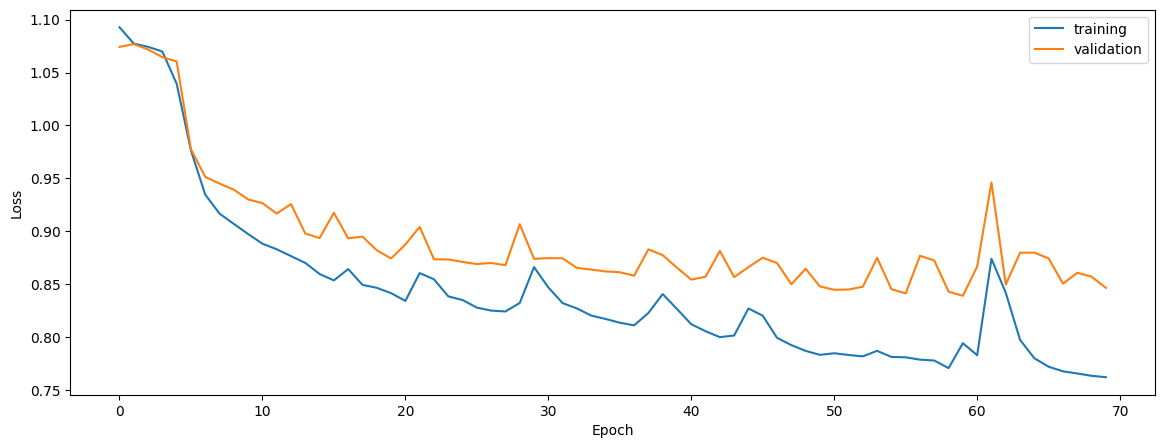

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.6505015928427212


0.6291067346238286


0.6330964625755786


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.7222327610736982


0.6920418170673568


0.7088800239813683


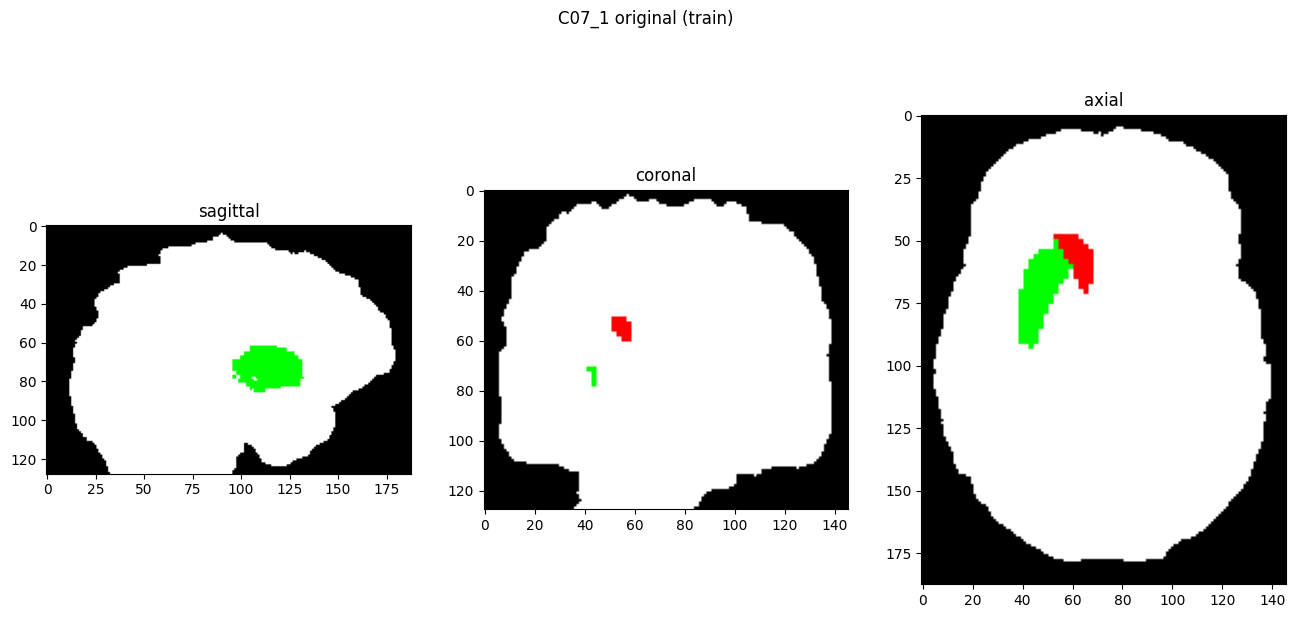

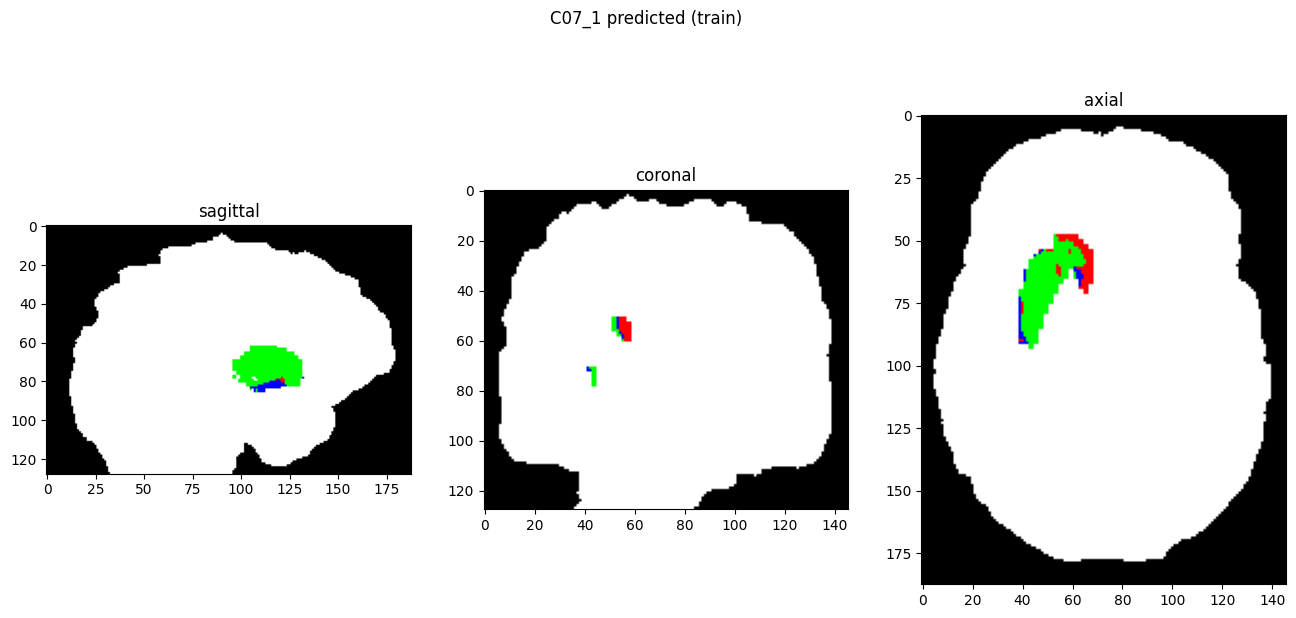

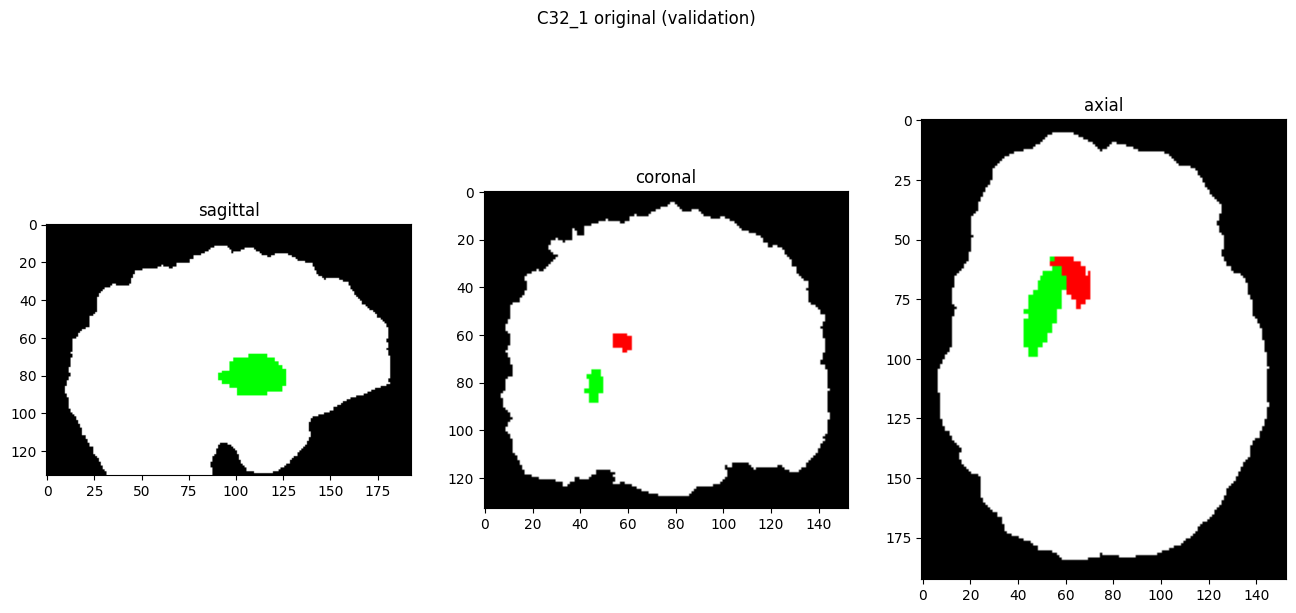

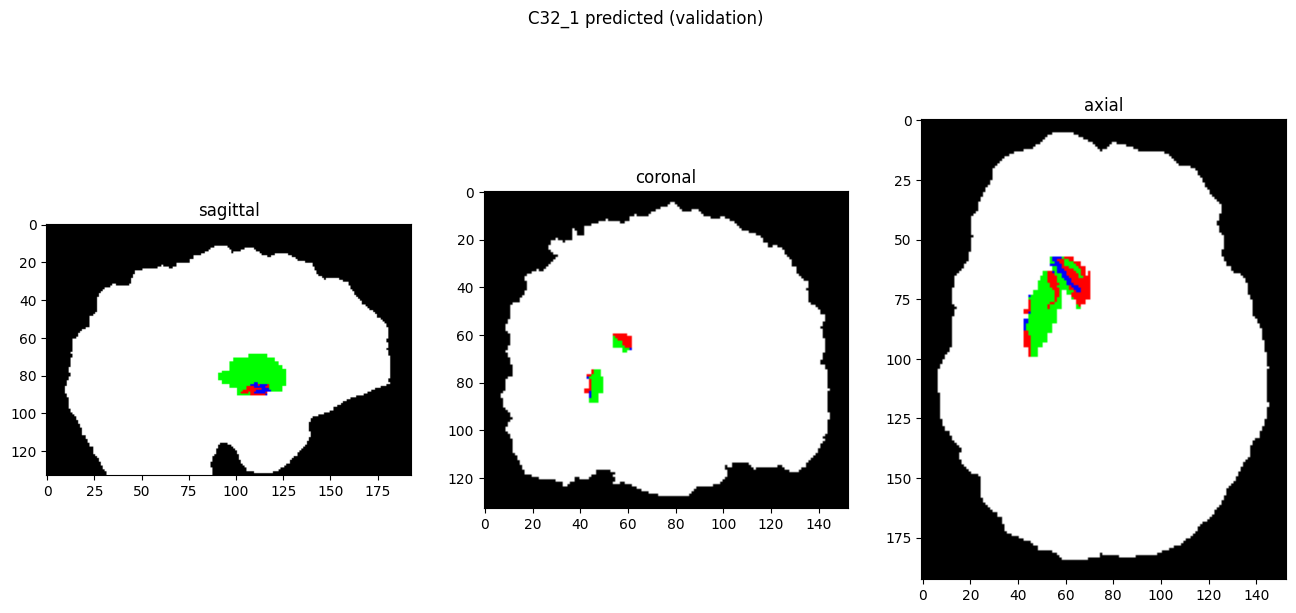

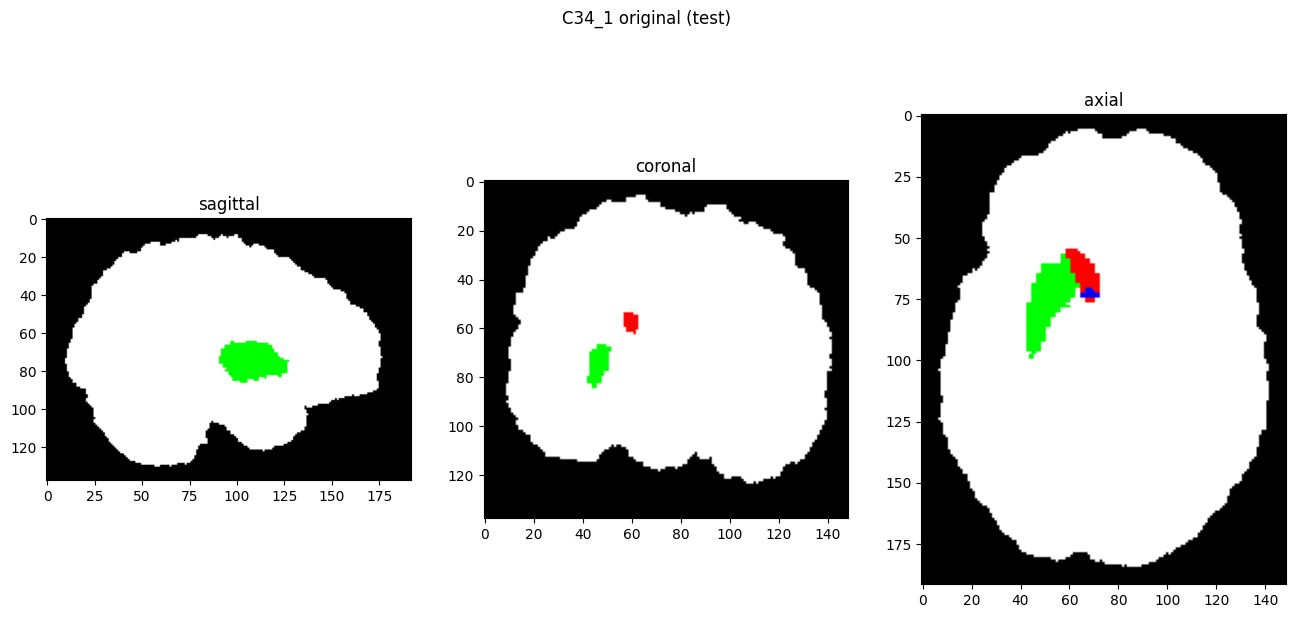

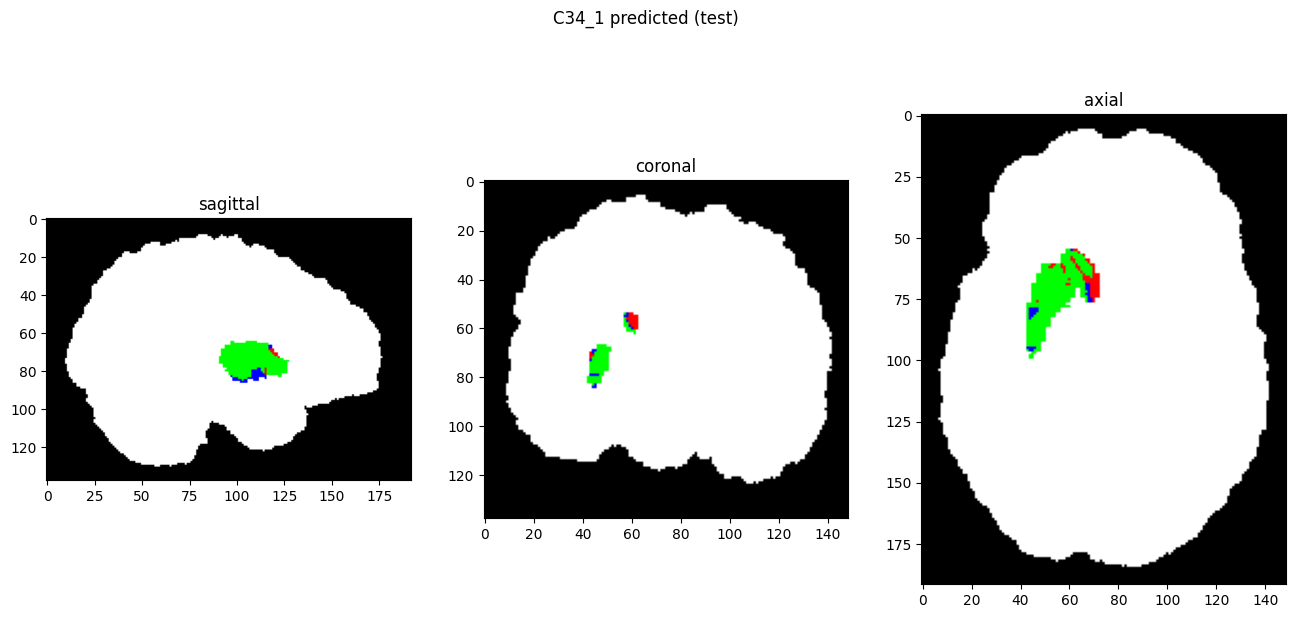

In [9]:
showResults(model, gen, threshold=0)